# Código de Procesamiento de Video (Práctica Especial - Detección de rayos cósmicos)

Autores: Brusco Agustín y Bruno Sivilotti

### Imports y formato

In [3]:
import os
import cv2  # OpenCv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.labelsize'] = 'large'
rcParams['figure.dpi'] = 120

### Preconfiguración del video a analizar:

Video info:
	filename : bueno1506.mp4
	shape : (450, 800)
	frame count : 9001


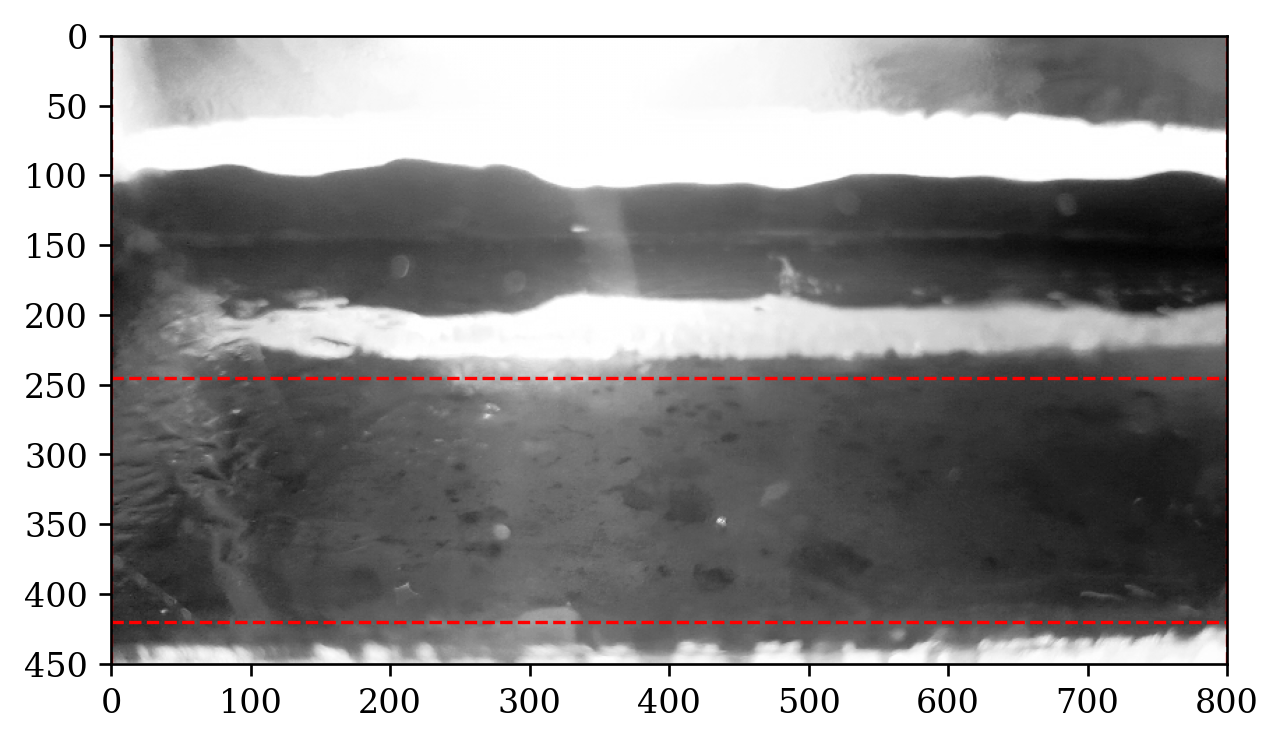

In [4]:
video_folder = r'/home/agus/Documents/2022 1er Cuatrimestre/Laboratorio 4/Práctica Especial/Código y Datos/Grabaciones'
os.chdir(video_folder)

videos = ['bueno1506.mp4', 'bueno1515.mp4', 'bueno1603.mp4', 'bueno1608.mp4',
          'bueno1635.mp4', 'bueno1641.mp4', 'bueno1708.mp4', 'bueno1729.mp4']
# Dict[video: ((frame_inicial, frame_final), (fila_inicial, fila_final), (columna_inicial, columna_final))]
regiones_trabajo = {'bueno1506.mp4': ((0, 9000), (245, 420), (0, 800)),
                    'bueno1515.mp4': ((0, 9000), (105, 400), (1, 790)),
                    'bueno1603.mp4': ((0, 9000), (105, 450), (0, 750)),
                    'bueno1608.mp4': ((0, 9000), (105, 450), (0, 750)),
                    'bueno1635.mp4': ((0, 9000), (200, 430), (0, 750)),
                    'bueno1641.mp4': ((0, 9000), (100, 350), (0, 700)),
                    'bueno1708.mp4': ((0, 9000), (120, 450), (0, 700)),
                    'bueno1729.mp4': ((0, 9000), (170, 400), (0, 700))}

file = videos[0]
# Inicializo el objeto VideoCapture que lee los frames del video
cap = cv2.VideoCapture(file)
vres = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Número de filas por frame
hres = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Número de columnas por frame
N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Número de frames
print(f'Video info:\n\tfilename : {file}\n\tshape : ({vres}, {hres})\n\tframe count : {N_frames}')
# Defino la región de cada imagen con la que vamos a trabajar
framerange, rowrange, colrange = regiones_trabajo[file]
region = tuple(np.meshgrid(np.arange(*rowrange),
                           np.arange(*colrange), indexing='ij'))
if rowrange[1] > vres or colrange[1] > hres:
    raise ValueError('La región seleccionada para este video excede las dimensiones del mismo.')
# Probar seteando varios frames que la región sea la adecuada:
cap.set(cv2.CAP_PROP_POS_FRAMES, 2412)  # variar este número entre 0 y 9000
retval, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Pasa a escala de grises

plt.imshow(frame, cmap='Greys_r')
for col in colrange:
    plt.axvline(col, c='r', ls='--', lw=1)
for row in rowrange:
    plt.axhline(row, c='r', ls='--', lw=1)
plt.xlim(0, hres)
plt.ylim(vres, 0)
plt.show()

### Lectura de resultados previos para esta grabación:

In [5]:
# Abre (si existen) o crea las listas donde se guardaran los resultados del análisis actual:
tag = file[:-4]
try:  # Trata de abrir la carpeta para con los resultados previos de este video.
    os.chdir(video_folder + '/' + f'resultados_{tag}')
    LineM = list(np.load(f'LineM_{tag}.npy', ))
    BetaM = list(np.load(f'BetaM_{tag}.npy', ))
    IdxM = list(np.load(f'IdxM_{tag}.npy', ))
    LineA = list(np.load(f'LineA_{tag}.npy', ))
    BetaA = list(np.load(f'BetaA_{tag}.npy', ))
    IdxA = list(np.load(f'IdxA_{tag}.npy', ))
    print('Archivos leídos exitosamente.')
    print(f'Detecciones Manuales Cargadas: {len(IdxM)}')
    print(f'Detecciones Semi-Automaticas Cargadas: {len(IdxA)}')
    print(f'Total: {len(IdxM) + len(IdxA)}')
    # Vuelve a la carpeta de grabaciones:
    os.chdir(video_folder)
except FileNotFoundError:  # Si no existe, crea listas vacías.
    # Detecciones Manuales
    LineM = []
    BetaM = []
    IdxM = []
    # Detecciones Semi-Automaticas
    LineA = []
    BetaA = []
    IdxA = []
    print('No se hallaron resultados previos para este video.')
    print(f'Detecciones Manuales Cargadas: {len(IdxM)}')
    print(f'Detecciones Semi-Automaticas Cargadas: {len(IdxA)}')



Archivos leídos exitosamente.
Detecciones Manuales Cargadas: 72
Detecciones Semi-Automaticas Cargadas: 37
Total: 109


### Programa de la interfaz:

In [5]:
# Dict[comando: código_tecla] # nombre_tecla
controles = {
    'detener': 27,  # Esc -> detener programa
    'pausa': 32,  # Espacio -> pausar/reanudar
    'siguiente': 99,  # c -> frame posterior (siguiente linea en modo detección)
    'anterior': 122,  # z -> frame anterior
    'lento': 115,  # s -> realentiza la velocidad de reproducción
    'rapido': 102,  # f -> acelera la velocidad de reproducción
    'deteccion': 13,  # Enter -> modo detección (guardar ángulo en modo detección))
    'atras': 8,  # Backspace -> salir del modo detección
    'manual': 109,  # m -> entrar modo detección manual
             }


def mouse_control(event, x, y, flag, userdata=None):
    global manual, x1, y1, x2, y2
    if manual:
        if event == cv2.EVENT_LBUTTONDOWN:
            x1, y1 = x, y
        if event == cv2.EVENT_LBUTTONUP:
            x2, y2 = x, y
    else:
        pass

# Algoritmo de extracción de fondo:
backSub = cv2.createBackgroundSubtractorMOG2(history=300,
                                             varThreshold=16,
                                             detectShadows=False)
# Inicializo parámetros del programa:
cap = cv2.VideoCapture(file)  # Video
dtheta = 2.  # ° : resolución en θ
dr = 20  # px : resolución en r
velocidad_reproduccion = 1  # Multiplicador/ 1 ≈ 30 fps
paused = False
manual = False

while True:
    ret, frame = cap.read()
    frame_idx = cap.get(cv2.CAP_PROP_POS_FRAMES)
    
    if frame is None:
        cv2.destroyWindow('Frame')
        cv2.destroyWindow('Mask')
        break
    # Preprocesamiento de la imagen (greyscale & resize)
    imag = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)[region]
    # Actualización del modelo de fondo
    if not paused:
        fgMask = backSub.apply(imag, learningRate=-1)  # Actualiza el modelo de fondo
    else:
        fgMask = backSub.apply(imag, learningRate=0)  # Lo mantiene en su estado anterior
    
    lines = cv2.HoughLinesP(image=fgMask, rho=dr, theta=dtheta*np.pi/180, threshold=10, minLineLength=10, maxLineGap=20)
    imag = cv2.cvtColor(fgMask, cv2.COLOR_GRAY2BGR)
    if lines is not None:  # Grafica las lineas detectadas automaticamente en rojo
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(imag, (x1, y1), (x2, y2), color=(0, 0, 255))
            cv2.line(frame, (colrange[0] + x1, rowrange[0]+ y1),(colrange[0] + x2, rowrange[0] + y2), color=(0, 0, 255))
    # Grafica las lineas que ya se hayan guardado en este frame con su color respectivo
    if frame_idx in IdxA:
        for id, line in zip(IdxA, LineA):
            if frame_idx == id:
                x1, y1, x2, y2 = line
                cv2.line(imag, (x1, y1), (x2, y2), color=(0, 255, 0))
                cv2.line(frame, (colrange[0] + x1, rowrange[0]+ y1),
                        (colrange[0] + x2, rowrange[0] + y2), color=(0, 255, 0))
    if frame_idx in IdxM:
        for id, line in zip(IdxM, LineM):
            if frame_idx == id:
                x1, y1, x2, y2 = line
                cv2.line(imag, (x1, y1), (x2, y2), color=(255, 0, 0))
                cv2.line(frame, (colrange[0] + x1, rowrange[0]+ y1),
                        (colrange[0] + x2, rowrange[0] + y2), color=(255, 0, 0))
    # Creo el rectangulo con texto en la esquina superior izquierda
    cv2.rectangle(frame, (10, 2), (120, 40), (255, 255, 255), -1)
    # Cuadrado Rojo indica pausa
    if paused:
        cv2.rectangle(frame, (100, 20), (120, 40), (0, 0, 255), -1)
    # Indico número de frame y velocidad de reproducción
    cv2.putText(frame, f'frame:{cap.get(cv2.CAP_PROP_POS_FRAMES):.0f}', (15, 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    cv2.putText(frame, f'(x{velocidad_reproduccion})', (15, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    # Muestra (actualiza) el fotograma y la máscara.
    cv2.imshow('Frame', frame)
    cv2.imshow('Mask', imag)
    

    key = cv2.waitKey(int(30/velocidad_reproduccion))
    if key == controles['pausa'] or paused:
        while True:
            paused = True
            # Cuadrado Rojo indica pausa
            cv2.rectangle(frame, (100, 20), (120, 40), (0, 0, 255), -1)
            cv2.imshow('Frame', frame)
            key = cv2.waitKey(0)
            if key == controles['detener']:  # Esc -> detener programa
                break
            elif key == controles['pausa']:  # Espacio -> reanudar
                paused = False
                break
            elif key == controles['anterior']:  # z -> frame anterior
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx-2)
                break
            elif key == controles['siguiente']:  # c -> frame posterior
                break
            elif key == controles['lento']:  # s -> realentiza la velocidad de reproducción
                velocidad_reproduccion *= 0.5
            elif key == controles['rapido']:  # f -> acelera la velocidad de reproducción
                velocidad_reproduccion *= 2.
            elif key == controles['deteccion']:  # Enter -> deteccion
                if lines is not None:
                    # Cuadrado Verde indica detección
                    cv2.rectangle(frame, (100, 20), (120, 40), (0, 255, 0), -1)
                    for line in lines:
                        x1, y1, x2, y2 = line[0]
                        
                        # Dibuja la linea seleccionada en verde
                        cv2.line(imag, (x1, y1), (x2, y2), color=(0, 255, 0))
                        cv2.line(frame, (colrange[0] + x1, rowrange[0]+ y1),
                                (colrange[0] + x2, rowrange[0] + y2), color=(0, 255, 0))
                        cv2.imshow('Frame', frame)
                        cv2.imshow('Mask', imag)
                        key = cv2.waitKey(0)
                        if key == controles['deteccion']:
                            if y1 - y2 == 0:
                                beta = np.pi/2
                            else:
                                beta = np.arctan((x2 - x1)/(y2 - y1))
                            BetaA.append(beta*180/np.pi)
                            LineA.append((x1, y1, x2, y2))
                            IdxA.append(frame_idx)
                            print('Nueva detección semi-automática:')
                            print(f'\tframe = {IdxA[-1]}, β = {BetaA[-1]:.0f}°')
                        elif key == controles['siguiente']:
                            cv2.line(imag, (x1, y1), (x2, y2), color=(0, 0, 255))
                            cv2.line(frame, (colrange[0] + x1, rowrange[0]+ y1),
                                    (colrange[0] + x2, rowrange[0] + y2), color=(0, 0, 255))
                            continue
                        elif key == controles['atras']:
                            break
            elif key == controles['manual'] or manual:
                manual = True
                cv2.setMouseCallback('Mask', mouse_control)
                while manual:
                    frameM = frame.copy()
                    imagM = imag.copy()
                    # Cuadrado Azul indica modo manual
                    cv2.rectangle(frameM, (100, 20), (120, 40), (255, 0, 0), -1)
                    # Dibuja la linea entre los puntos marcados en azul
                    cv2.line(imagM, (x1, y1), (x2, y2), color=(255, 0, 0))
                    cv2.line(frameM, (colrange[0] + x1, rowrange[0]+ y1),
                            (colrange[0] + x2, rowrange[0] + y2), color=(255, 0, 0))
                    cv2.imshow('Frame', frameM)
                    cv2.imshow('Mask', imagM)
                    key = cv2.waitKey(0)
                    if key == controles['deteccion']:
                        if y1 - y2 == 0:
                            beta = np.pi/2
                        else:
                            beta = np.arctan((x2 - x1)/(y2 - y1))
                        BetaM.append(beta*180/np.pi)
                        LineM.append((x1, y1, x2, y2))
                        IdxM.append(frame_idx)
                        print('Nueva detección manual:')
                        print(f'\tframe = {IdxM[-1]}, β = {BetaM[-1]:.0f}°')
                    elif key == controles['atras']:
                        manual = False
    if key == controles['detener']:  # Esc -> detener programa
        cv2.destroyWindow('Frame')
        cv2.destroyWindow('Mask')
        break
    elif key == controles['lento']:  # s -> realentiza la velocidad de reproducción
        velocidad_reproduccion *= 0.5
    elif key == controles['rapido']:  # f -> acelera la velocidad de reproducción
        velocidad_reproduccion *= 2.

print(f'Procesamiento detenido en el frame {frame_idx:.0f} de {N_frames}')

Procesamiento detenido en el frame 1384 de 8998


### Guardado de los resultados:

In [8]:
# Conversión de listas a arrays
# Detecciones Manuales
LineM = np.array(LineM)
BetaM = np.array(BetaM)
IdxM = np.array(IdxM)
# Detecciones Semi-Automaticas
LineA = np.array(LineA)
BetaA = np.array(BetaA)
IdxA = np.array(IdxA)


tag = file[:-4]
try:  # Prueba a crear la carpeta para guardar los resultados de este video.
    os.mkdir(f'resultados_{tag}')
except FileExistsError:  # Si ya existe, simplemente continua.
    pass
# Va a la carpeta de resultados de este video.
os.chdir(video_folder + '/' + f'resultados_{tag}')
# Guarda los resultados.
np.save(f'LineM_{tag}.npy', LineM)
np.save(f'BetaM_{tag}.npy', BetaM)
np.save(f'IdxM_{tag}.npy', IdxM)
np.save(f'LineA_{tag}.npy', LineA)
np.save(f'BetaA_{tag}.npy', BetaA)
np.save(f'IdxA_{tag}.npy', IdxA)
print(f'{len(IdxA) + len(IdxM)} resultados guardados en {os.getcwd()}.')
# Vuelve a la carpeta de los videos.
os.chdir(video_folder)

60 resultados guardados en /home/agus/Documents/2022 1er Cuatrimestre/Laboratorio 4/Práctica Especial/Código y Datos/Grabaciones/resultados_bueno1608.


### Histograma de los resultados actuales:

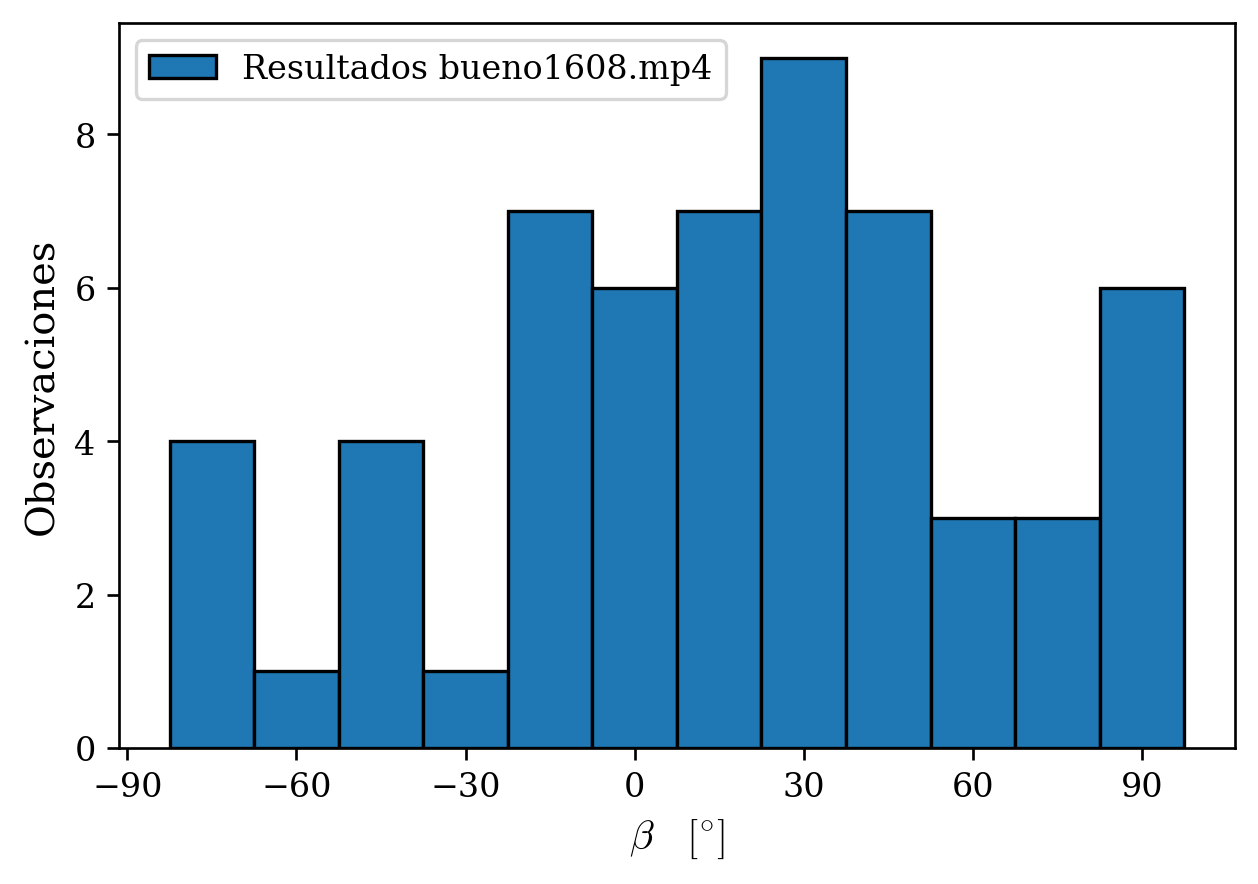

In [9]:
t = thetas = np.arange(90, -90, -15)[::-1]
theta_bin_edges = np.concatenate([thetas - 15/2,
                                     [thetas[-1] + 15/2, ]])  # °
plt.hist(np.concatenate([BetaA,BetaM]), bins=theta_bin_edges, edgecolor='k',
         label=f'Resultados {file}')
plt.legend()
plt.xticks(np.arange(90, -91, -30))
plt.xlabel(r'$\beta \quad \mathrm{[^{\circ}]}$')
plt.ylabel('Observaciones')
plt.show()